In [479]:
import warnings
warnings.filterwarnings('ignore')

In [480]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from scipy import stats

In [481]:
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
matplotlib.rcParams['figure.dpi'] = 125
pd.set_option('display.max_columns', None)

In [482]:
from metrics import evaluate # metrics.py
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.ar_model import AR
from scipy.optimize import minimize
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### Kansas (KS) — Grant

#### Average temperature

In [483]:
# Grant (avg_temp)
df_avg_temp_Grant = pd.read_csv('../Data_KS_WA/KS/KS_Climate/KS_Grant_Avg_Temp_Additional.csv').drop(['Anomaly'], axis=1)
df_avg_temp_Grant.rename(columns={'Value':'Avg_Temp'}, inplace=True)
df_avg_temp_Grant['Year'] = df_avg_temp_Grant['Date'].apply(lambda x: int(str(x)[:4]))
df_avg_temp_Grant['Month'] = df_avg_temp_Grant['Date'].apply(lambda x: int(str(x)[-2:]))
df_avg_temp_Grant = df_avg_temp_Grant.drop(['Date'], axis=1)

print(df_avg_temp_Grant.shape)
df_avg_temp_Grant.head()

(1500, 3)


,Avg_Temp,Year,Month
0,26.9,1895,1
1,24.4,1895,2
2,40.3,1895,3
3,57.8,1895,4
4,64.7,1895,5


#### Precipitation

In [484]:
# Grant (precipitation)
df_precipitation_Grant = pd.read_csv('../Data_KS_WA/KS/KS_Climate/KS_Grant_Precipitation.csv', skiprows=4).drop(['Anomaly'], axis=1)
df_precipitation_Grant.rename(columns={'Value':'Precipitation'}, inplace=True)
df_precipitation_Grant['Year'] = df_precipitation_Grant['Date'].apply(lambda x: int(str(x)[:4]))
df_precipitation_Grant['Month'] = df_precipitation_Grant['Date'].apply(lambda x: int(str(x)[-2:]))
df_precipitation_Grant = df_precipitation_Grant.drop(['Date'], axis=1)

print(df_precipitation_Grant.shape)
df_precipitation_Grant.head()

(371, 3)


,Precipitation,Year,Month
0,0.41,1989,1
1,0.40,1989,2
2,0.32,1989,3
3,0.55,1989,4
4,5.56,1989,5


#### Drought (PDSI)

In [485]:
df_drought_KS = pd.read_csv('../Data_KS_WA/KS/KS_Climate/KS_PDSI.csv', skiprows=3).drop(['Anomaly'], axis=1)
df_drought_KS.rename(columns={'Value':'PDSI'}, inplace=True)
df_drought_KS['Year'] = df_drought_KS['Date'].apply(lambda x: int(str(x)[:4]))
df_drought_KS['Month'] = df_drought_KS['Date'].apply(lambda x: int(str(x)[-2:]))
df_drought_KS = df_drought_KS.drop(['Date'], axis=1)

print(df_drought_KS.shape)
df_drought_KS.head()

(371, 3)


,PDSI,Year,Month
0,-2.70,1989,1
1,-2.86,1989,2
2,-2.99,1989,3
3,-3.88,1989,4
4,-3.85,1989,5


#### Adding climate data to Cause_of_Loss datasets (by county for KS)

In [486]:
# Grant
df_loss_Grant = pd.read_csv('../Data_KS_WA/KS/KS_Cause_of_Loss/KS_Grant_Cause_of_Loss.csv') 
df_loss_Grant.Month.replace({'Unspecified': 0}, inplace=True)
df_loss_Grant['Year'] = pd.to_numeric(df_loss_Grant['Year'], downcast='integer')
df_loss_Grant['Month'] = pd.to_numeric(df_loss_Grant['Month'], downcast='integer')
df_loss_Grant_merged = pd.merge(df_loss_Grant, df_avg_temp_Grant, how='left', on=['Year', 'Month'])
df_loss_Grant_merged = pd.merge(df_loss_Grant_merged, df_precipitation_Grant, how='left', on=['Year', 'Month'])
df_loss_Grant_merged = pd.merge(df_loss_Grant_merged, df_drought_KS, how='left', on=['Year', 'Month'])

# print(df_loss_Grant_merged.shape)
# df_loss_Grant_merged.head(10)

In [487]:
losses_Grant = df_loss_Grant_merged['Cause of loss'].unique()

print(df_loss_Grant_merged['Cause of loss'].nunique(), 'unique causes of loss')
df_loss_Grant_merged['Cause of loss'].value_counts()

20 unique causes of loss


Drought                         196
Freeze                           97
Wind/excess Wind                 83
Heat                             79
Hail                             71
Hot Wind                         71
Cold Winter                      67
Decline In Price                 54
Excess Moisture/precip/rain      33
Other                            29
Plant Disease                    29
Frost                            11
Cold Wet Weather                 10
Insects                           7
Failure Of Irrigation Supply      5
Area Plan Crops Only              4
Cyclone                           2
Flood                             1
Wildlife                          1
Fire                              1
Name: Cause of loss, dtype: int64

#### Condensing data to annual

In [488]:
# Grant
df_loss_Grant_merged_clean = df_loss_Grant_merged.dropna().drop(['State', 'County', 'Month'], axis=1)

# print(df_loss_Grant_merged_clean.shape)
# df_loss_Grant_merged_clean.head()

In [489]:
num_cols = list(df_loss_Grant_merged_clean.select_dtypes(include=[np.number]).columns.values)

In [490]:
df_avg_Grant = df_loss_Grant_merged_clean.groupby(['Year']).mean().reset_index()
df_concat_Grant = df_loss_Grant_merged_clean[['Cause of loss', 'Year']].groupby(['Year']).agg(lambda x: tuple(x)).applymap(list).reset_index()
df_annual_Grant = pd.merge(df_avg_Grant, df_concat_Grant, how='left', on=['Year'])
df_annual_Grant['County name'] = 'Grant'

# print(df_annual_Grant.shape)
# df_annual_Grant.head()

#### Adding loss ratio data

In [491]:
# loss ratio
df_insurance_KS = pd.read_csv('../Data_KS_WA/KS/KS_Report_Generator.csv')
df_insurance_KS = df_insurance_KS[df_insurance_KS['Commodity Name'] != 'All Other Commodities']
df_insurance_KS_Grant = df_insurance_KS[df_insurance_KS['County Name'] == 'Grant']
df_insurance_KS_Grant.rename(columns={'Commodity Year':'Year'}, inplace=True)

# merging
df_annual_Grant_insurance = pd.merge(df_annual_Grant[['Year', 'Avg_Temp', 'Precipitation', 'PDSI', 'Cause of loss']], 
                                     df_insurance_KS_Grant, how='left', on=['Year']).reset_index().drop(['Commodity Name', 'State Abbrv', 'index'], axis=1)

# print(df_annual_Grant_insurance.shape)
# df_annual_Grant_insurance.head()

#### Adding production data

In [492]:
# production
df_production_KS = pd.read_csv('../Data_KS_WA/KS/KS_Agriculture/KS_County_Production_Bushels.csv')
df_production_KS_select = df_production_KS.copy()[['Year', 'County','Value']]
df_production_KS_select.rename(columns={'Value':'Bushels'}, inplace=True)
pd.to_numeric(df_production_KS_select['Year'], downcast='integer')
df_production_KS_select['County'] = df_production_KS_select['County'].str.capitalize() 
df_production_KS_select = df_production_KS_select.rename(columns={'County': 'County Name'})
df_production_KS_select['Bushels'] = df_production_KS_select['Bushels'].str.replace(',','').astype(int)
df_production_KS_Grant = df_production_KS_select[df_production_KS_select['County Name'] == 'Grant']
df_production_KS_Grant.drop(columns=['County Name'], axis=1, inplace=True)

# merging
df_Grant_all = pd.merge(df_annual_Grant_insurance, df_production_KS_Grant, how='left', on=['Year']).reset_index().drop(['index'], axis=1)

# print(df_Grant_all.shape)
# df_Grant_all.head()

In [493]:
print(df_Grant_all.columns)

Index(['Year', 'Avg_Temp', 'Precipitation', 'PDSI', 'Cause of loss',
       'County Name', 'Policies Sold', 'Policies Earning Prem',
       'Policies Indemnified', 'Units Earning Prem', 'Units Indemnified',
       'Quantity', 'Quantity Type', 'Companion/Endorsed Acres',
       'Liabilities ($)', 'Total Prem ($)', 'Subsidy ($)', 'Indemnity ($)',
       'EFA Prem Discount ($)', 'Addnl Subsidy ($)', 'State Subsidy ($)',
       'Earn Prem Rate', 'Loss Ratio', 'Bushels'],
      dtype='object')


In [494]:
select_cols = ['County Name', 'Year', 'Avg_Temp', 'Precipitation', 'PDSI', 'Cause of loss', 'Loss Ratio']
df_Grant_model = df_Grant_all[select_cols]

# print(df_Grant_model.shape)
# df_Grant_model.head()

### Washington (WA) — Spokane, Whitman

#### Average temperature

In [495]:
# Spokane (avg_temp)
df_avg_temp_Spokane = pd.read_csv('../Data_KS_WA/WA/WA_Climate/WA_Spokane_Avg_Temp_Additional.csv').drop(['Anomaly'], axis=1)
df_avg_temp_Spokane.rename(columns={'Value':'Avg_Temp'}, inplace=True)
df_avg_temp_Spokane['Year'] = df_avg_temp_Spokane['Date'].apply(lambda x: int(str(x)[:4]))
df_avg_temp_Spokane['Month'] = df_avg_temp_Spokane['Date'].apply(lambda x: int(str(x)[-2:]))
df_avg_temp_Spokane = df_avg_temp_Spokane.drop(['Date'], axis=1)

# print(df_avg_temp_Spokane.shape)
# df_avg_temp_Spokane.head()

In [496]:
# Whitman (avg_temp)
df_avg_temp_Whitman = pd.read_csv('../Data_KS_WA/WA/WA_Climate/WA_Whitman_Avg_Temp_Additional.csv').drop(['Anomaly'], axis=1)
df_avg_temp_Whitman.rename(columns={'Value':'Avg_Temp'}, inplace=True)
df_avg_temp_Whitman['Year'] = df_avg_temp_Whitman['Date'].apply(lambda x: int(str(x)[:4]))
df_avg_temp_Whitman['Month'] = df_avg_temp_Whitman['Date'].apply(lambda x: int(str(x)[-2:]))
df_avg_temp_Whitman = df_avg_temp_Whitman.drop(['Date'], axis=1)

# print(df_avg_temp_Whitman.shape)
# df_avg_temp_Whitman.head()

#### Precipitation

In [497]:
# Spokane (precipitation)
df_precipitation_Spokane = pd.read_csv('../Data_KS_WA/WA/WA_Climate/WA_Spokane_Precipitation.csv').drop(['Anomaly'], axis=1)
df_precipitation_Spokane.rename(columns={'Value':'Precipitation'}, inplace=True)
df_precipitation_Spokane['Year'] = df_precipitation_Spokane['Date'].apply(lambda x: int(str(x)[:4]))
df_precipitation_Spokane['Month'] = df_precipitation_Spokane['Date'].apply(lambda x: int(str(x)[-2:]))
df_precipitation_Spokane = df_precipitation_Spokane.drop(['Date'], axis=1)

# print(df_precipitation_Spokane.shape)
# df_precipitation_Spokane.head()

In [498]:
# Whitman (precipitation)
df_precipitation_Whitman = pd.read_csv('../Data_KS_WA/WA/WA_Climate/WA_Whitman_Precipitation.csv').drop(['Anomaly'], axis=1)
df_precipitation_Whitman.rename(columns={'Value':'Precipitation'}, inplace=True)
df_precipitation_Whitman['Year'] = df_precipitation_Whitman['Date'].apply(lambda x: int(str(x)[:4]))
df_precipitation_Whitman['Month'] = df_precipitation_Whitman['Date'].apply(lambda x: int(str(x)[-2:]))
df_precipitation_Whitman = df_precipitation_Whitman.drop(['Date'], axis=1)

# print(df_precipitation_Whitman.shape)
# df_precipitation_Whitman.head()

#### Drought (PDSI)

In [499]:
df_drought_WA = pd.read_csv('../Data_KS_WA/WA/WA_Climate/WA_PDSI.csv', skiprows=3).drop(['Anomaly'], axis=1)
df_drought_WA.rename(columns={'Value':'PDSI'}, inplace=True)
df_drought_WA['Year'] = df_drought_WA['Date'].apply(lambda x: int(str(x)[:4]))
df_drought_WA['Month'] = df_drought_WA['Date'].apply(lambda x: int(str(x)[-2:]))
df_drought_WA = df_drought_WA.drop(['Date'], axis=1)

# print(df_drought_WA.shape)
# df_drought_WA.head()

#### Adding climate data to Cause_of_Loss datasets (by county for WA)

In [500]:
# Spokane
df_loss_Spokane = pd.read_csv('../Data_KS_WA/WA/WA_Cause_of_Loss/WA_Spokane_Cause_of_Loss.csv') 
df_loss_Spokane.Month.replace({'Unspecified': 0}, inplace=True)
df_loss_Spokane['Year'] = pd.to_numeric(df_loss_Spokane['Year'], downcast='integer')
df_loss_Spokane['Month'] = pd.to_numeric(df_loss_Spokane['Month'], downcast='integer')
df_loss_Spokane_merged = pd.merge(df_loss_Spokane, df_avg_temp_Spokane, how='left', on=['Year', 'Month'])
df_loss_Spokane_merged = pd.merge(df_loss_Spokane_merged, df_precipitation_Spokane, how='left', on=['Year', 'Month'])
df_loss_Spokane_merged = pd.merge(df_loss_Spokane_merged, df_drought_WA, how='left', on=['Year', 'Month'])

# print(df_loss_Spokane_merged.shape)
# df_loss_Spokane_merged.head()

In [501]:
losses_Spokane = df_loss_Spokane_merged['Cause of loss'].unique()

print(df_loss_Spokane_merged['Cause of loss'].nunique(), 'unique causes of loss')
df_loss_Spokane_merged['Cause of loss'].value_counts()

18 unique causes of loss


Drought                        125
Heat                            56
Decline In Price                46
Cold Wet Weather                46
Excess Moisture/precip/rain     45
Cold Winter                     42
Frost                           38
Freeze                          23
Hail                            14
Other                           11
Wind/excess Wind                10
Insects                          8
Plant Disease                    8
Falling Numbers                  5
Flood                            4
Cyclone                          2
Fire                             2
Wildlife                         1
Name: Cause of loss, dtype: int64

In [502]:
# Whitman
df_loss_Whitman = pd.read_csv('../Data_KS_WA/WA/WA_Cause_of_Loss/WA_Whitman_Cause_of_Loss.csv') 
df_loss_Whitman.Month.replace({'Unspecified': 0}, inplace=True)
df_loss_Whitman['Year'] = pd.to_numeric(df_loss_Whitman['Year'], downcast='integer')
df_loss_Whitman['Month'] = pd.to_numeric(df_loss_Whitman['Month'], downcast='integer')
df_loss_Whitman_merged = pd.merge(df_loss_Whitman, df_avg_temp_Whitman, how='left', on=['Year', 'Month'])
df_loss_Whitman_merged = pd.merge(df_loss_Whitman_merged, df_precipitation_Whitman, how='left', on=['Year', 'Month'])
df_loss_Whitman_merged = pd.merge(df_loss_Whitman_merged, df_drought_WA, how='left', on=['Year', 'Month'])

# print(df_loss_Whitman_merged.shape)
# df_loss_Whitman_merged.head()

In [503]:
losses_Whitman = df_loss_Whitman_merged['Cause of loss'].unique()

print(df_loss_Whitman_merged['Cause of loss'].nunique(), 'unique causes of loss')
df_loss_Whitman_merged['Cause of loss'].value_counts()

23 unique causes of loss


Drought                            199
Heat                               118
Cold Winter                         88
Excess Moisture/precip/rain         78
Cold Wet Weather                    73
Decline In Price                    68
Frost                               60
Freeze                              56
Other                               36
Plant Disease                       29
Hail                                22
Wind/excess Wind                    20
Flood                                7
Falling Numbers                      6
Fire                                 6
Erosion                              5
Insects                              4
Wildlife                             3
Hot Wind                             3
Cyclone                              2
No Indemnity                         2
Failure Of Irrigation Supply         1
Failure Of Irrigation Equipment      1
Name: Cause of loss, dtype: int64

#### Condensing data to annual

Spokane

In [504]:
# Spokane
df_loss_Spokane_merged_clean = df_loss_Spokane_merged.dropna().drop(['State', 'County', 'Month'], axis=1)
print(df_loss_Spokane_merged_clean.shape)

(479, 13)


In [505]:
df_avg_Spokane = df_loss_Spokane_merged_clean.groupby(['Year']).mean().reset_index()
df_concat_Spokane = df_loss_Spokane_merged_clean[['Cause of loss', 'Year']].groupby(['Year']).agg(lambda x: tuple(x)).applymap(list).reset_index()
df_annual_Spokane = pd.merge(df_avg_Spokane, df_concat_Spokane, how='left', on=['Year'])
df_annual_Spokane['County name'] = 'Spokane'

# print(df_annual_Spokane.shape)
# df_annual_Spokane.head()

Whitman

In [506]:
# Whitman
df_loss_Whitman_merged_clean = df_loss_Whitman_merged.dropna().drop(['State', 'County', 'Month'], axis=1)
print(df_loss_Whitman_merged_clean.shape)

(854, 13)


In [507]:
df_avg_Whitman = df_loss_Whitman_merged_clean.groupby(['Year']).mean().reset_index()
df_concat_Whitman = df_loss_Whitman_merged_clean[['Cause of loss', 'Year']].groupby(['Year']).agg(lambda x: tuple(x)).applymap(list).reset_index()
df_annual_Whitman = pd.merge(df_avg_Whitman, df_concat_Whitman, how='left', on=['Year'])
df_annual_Whitman['County name'] = 'Whitman'

# print(df_annual_Whitman.shape)
# df_annual_Whitman.head()

#### Adding loss ratio data

Spokane

In [508]:
# loss ratio
df_insurance_WA = pd.read_csv('../Data_KS_WA/WA/WA_Report_Generator.csv')
df_insurance_WA = df_insurance_WA[df_insurance_WA['Commodity Name'] != 'All Other Commodities']
df_insurance_WA_Spokane = df_insurance_WA[df_insurance_WA['County Name'] == 'Spokane']
df_insurance_WA_Spokane.rename(columns={'Commodity Year':'Year'}, inplace=True)

# merging
df_annual_Spokane_insurance = pd.merge(df_annual_Spokane[['Year', 'Avg_Temp', 'Precipitation', 'PDSI', 'Cause of loss']], 
                                       df_insurance_WA_Spokane, how='left', on=['Year']).reset_index().drop(['Commodity Name', 'State Abbrv', 'index'], axis=1)

# print(df_annual_Spokane_insurance.shape)
# df_annual_Spokane_insurance.head()

Whitman

In [509]:
# loss ratio
df_insurance_WA = pd.read_csv('../Data_KS_WA/WA/WA_Report_Generator.csv')
df_insurance_WA = df_insurance_WA[df_insurance_WA['Commodity Name'] != 'All Other Commodities']
df_insurance_WA_Whitman = df_insurance_WA[df_insurance_WA['County Name'] == 'Whitman']
df_insurance_WA_Whitman.rename(columns={'Commodity Year':'Year'}, inplace=True)

# merging
df_annual_Whitman_insurance = pd.merge(df_annual_Whitman[['Year', 'Avg_Temp', 'Precipitation', 'PDSI', 'Cause of loss']], 
                                       df_insurance_WA_Whitman, how='left', on=['Year']).reset_index().drop(['Commodity Name', 'State Abbrv', 'index'], axis=1)

# print(df_annual_Whitman_insurance.shape)
# df_annual_Whitman_insurance.head()

#### Adding production data

Spokane

In [510]:
# production
df_production_WA = pd.read_csv('../Data_KS_WA/WA/WA_Agriculture/WA_County_Production_Bushels.csv')
df_production_WA_select = df_production_WA.copy()[['Year', 'County','Value']]
df_production_WA_select.rename(columns={'Value':'Bushels'}, inplace=True)
pd.to_numeric(df_production_WA_select['Year'], downcast='integer')
df_production_WA_select['County'] = df_production_WA_select['County'].str.capitalize() 
df_production_WA_select = df_production_WA_select.rename(columns={'County': 'County Name'})
df_production_WA_select['Bushels'] = df_production_WA_select['Bushels'].str.replace(',','').astype(int)
df_production_WA_Spokane = df_production_WA_select[df_production_WA_select['County Name'] == 'Spokane']
df_production_WA_Spokane.drop(columns=['County Name'], axis=1, inplace=True)

# merging
df_Spokane_all = pd.merge(df_annual_Spokane_insurance, df_production_WA_Spokane, how='left', on=['Year']).reset_index().drop(['index'], axis=1)

# print(df_Spokane_all.shape)
# df_Spokane_all.head()

In [511]:
df_Spokane_model = df_Spokane_all[select_cols]

# print(df_Spokane_model.shape)
# df_Spokane_model.head()

Whitman

In [512]:
# production
df_production_WA = pd.read_csv('../Data_KS_WA/WA/WA_Agriculture/WA_County_Production_Bushels.csv')
df_production_WA_select = df_production_WA.copy()[['Year', 'County','Value']]
df_production_WA_select.rename(columns={'Value':'Bushels'}, inplace=True)
pd.to_numeric(df_production_WA_select['Year'], downcast='integer')
df_production_WA_select['County'] = df_production_WA_select['County'].str.capitalize() 
df_production_WA_select = df_production_WA_select.rename(columns={'County': 'County Name'})
df_production_WA_select['Bushels'] = df_production_WA_select['Bushels'].str.replace(',','').astype(int)
df_production_WA_Whitman = df_production_WA_select[df_production_WA_select['County Name'] == 'Whitman']
df_production_WA_Whitman.drop(columns=['County Name'], axis=1, inplace=True)

# merging
df_Whitman_all = pd.merge(df_annual_Whitman_insurance, df_production_WA_Whitman, how='left', on=['Year']).reset_index().drop(['index'], axis=1)

# print(df_Whitman_all.shape)
# df_Whitman_all.head()

In [513]:
df_Whitman_model = df_Whitman_all[select_cols]

# print(df_Whitman_model.shape)
# df_Whitman_model.head()

### Featurizing causes of loss

In [514]:
losses = set(losses_Grant).union(set(losses_Spokane), set(losses_Whitman))
print(len(losses), 'total types of causes of loss')
print(losses)

24 total types of causes of loss
{'Hail', 'Freeze', 'Frost', 'Fire', 'Erosion', 'Cold Wet Weather', 'Failure Of Irrigation Supply', 'Flood', 'Cold Winter', 'Wildlife', 'Area Plan Crops Only', 'Insects', 'Failure Of Irrigation Equipment', 'No Indemnity', 'Falling Numbers', 'Heat', 'Decline In Price', 'Drought', 'Plant Disease', 'Wind/excess Wind', 'Other', 'Hot Wind', 'Excess Moisture/precip/rain', 'Cyclone'}


In [515]:
def featurize(causes):
    '''
    Featurizes causes of loss list by category (temperature, precipitation, other).
    '''
    temp_based = ['Cold Wet Weather', 'Cold Winter', 'Frost', 'Hot Wind', 'Freeze', 'Heat', 'Fire']
    precip_based = ['Hail', 'Flood', 'Excess Moisture/precip/rain', 'Cyclone', 'Drought']
    other = ['Falling Numbers', 'Failure Of Irrigation Equipment', 'No Indemnity', 'Erosion', 
             'Wind/excess Wind', 'Other', 'Decline In Price', 'Insects', 'Wildlife', 'Area Plan Crops Only', 
             'Failure Of Irrigation Supply', 'Plant Disease']
    causes_dict = {'temperature':0, 'precipitation':0, 'other':0}
    for cause in causes:
        if cause in temp_based:
            causes_dict['temperature'] += 1
        elif cause in precip_based:
            causes_dict['precipitation'] += 1
        else:
            causes_dict['other'] += 1
    norm = {k: v*(1.0/sum(causes_dict.values())) for k, v in causes_dict.items()}
    return [norm['temperature'], norm['precipitation'], norm['other']]

Grant

In [516]:
df_Grant_model['causes_of_loss'] = df_Grant_model['Cause of loss'].apply(featurize)
df_Grant_model = pd.concat([pd.DataFrame(df_Grant_model['causes_of_loss'].to_list(), 
                            columns=['temp', 'precip', 'other']), df_Grant_model], axis=1)
df_Grant_model = df_Grant_model.drop(['Cause of loss', 'causes_of_loss'], axis=1)

print(df_Grant_model.shape)
df_Grant_model.head()

(31, 9)


,temp,precip,other,County Name,Year,Avg_Temp,Precipitation,PDSI,Loss Ratio
0,0.333333,0.466667,0.200000,Grant,1989,47.493333,1.324667,-2.203333,2.216181
1,0.333333,0.333333,0.333333,Grant,1991,48.766667,1.020000,-2.213333,0.026550
2,0.500000,0.166667,0.333333,Grant,1992,50.850000,1.120000,1.406667,0.160988
3,0.200000,0.600000,0.200000,Grant,1993,52.500000,1.624000,6.650000,0.156027
4,0.375000,0.500000,0.125000,Grant,1994,53.212500,1.263750,4.630000,3.751074


Spokane

In [517]:
df_Spokane_model['causes_of_loss'] = df_Spokane_model['Cause of loss'].apply(featurize)
df_Spokane_model = pd.concat([pd.DataFrame(df_Spokane_model['causes_of_loss'].to_list(), 
                            columns=['temp', 'precip', 'other']), df_Spokane_model], axis=1)
df_Spokane_model = df_Spokane_model.drop(['Cause of loss', 'causes_of_loss'], axis=1)

print(df_Spokane_model.shape)
df_Spokane_model.head()

(31, 9)


,temp,precip,other,County Name,Year,Avg_Temp,Precipitation,PDSI,Loss Ratio
0,0.400000,0.600000,0.000000,Spokane,1989,43.950000,1.368000,-1.53300,0.717932
1,0.222222,0.555556,0.222222,Spokane,1992,54.122222,1.406667,-2.83000,1.316238
2,0.400000,0.200000,0.400000,Spokane,1993,61.120000,1.060000,2.30000,0.218274
3,0.375000,0.625000,0.000000,Spokane,1994,55.475000,0.990000,-2.34125,0.721820
4,0.500000,0.500000,0.000000,Spokane,1995,50.200000,1.652500,0.83000,0.042694


Whitman

In [518]:
df_Whitman_model['causes_of_loss'] = df_Whitman_model['Cause of loss'].apply(featurize)
df_Whitman_model = pd.concat([pd.DataFrame(df_Whitman_model['causes_of_loss'].to_list(), 
                            columns=['temp', 'precip', 'other']), df_Whitman_model], axis=1)
df_Whitman_model = df_Whitman_model.drop(['Cause of loss', 'causes_of_loss'], axis=1)

print(df_Whitman_model.shape)
df_Whitman_model.head()

(33, 9)


,temp,precip,other,County Name,Year,Avg_Temp,Precipitation,PDSI,Loss Ratio
0,0.520000,0.440000,0.040000,Whitman,1989,51.512000,1.097200,-1.413600,1.233943
1,0.444444,0.555556,0.000000,Whitman,1990,61.188889,1.093333,1.131111,0.088986
2,0.782609,0.217391,0.000000,Whitman,1991,51.343478,1.132609,0.661304,0.526554
3,0.400000,0.342857,0.257143,Whitman,1992,52.802857,1.056857,-2.859143,1.555545
4,0.434783,0.304348,0.260870,Whitman,1993,50.178261,1.320870,-0.338696,0.126128


### PDSI model

#### Kansas (KS) data

In [519]:
df_drought_KS['Month'] = df_drought_KS.Month.map('{:02}'.format)
df_drought_KS['Day'] = 1
df_drought_KS['Date'] = pd.to_datetime(df_drought_KS[['Year', 'Month', 'Day']])
df_drought_KS['month_year'] = pd.to_datetime(df_drought_KS['Date']).dt.to_period('M')

print(df_drought_KS.shape)
df_drought_KS.head()

(371, 6)


,PDSI,Year,Month,Day,Date,month_year
0,-2.70,1989,01,1,1989-01-01,1989-01
1,-2.86,1989,02,1,1989-02-01,1989-02
2,-2.99,1989,03,1,1989-03-01,1989-03
3,-3.88,1989,04,1,1989-04-01,1989-04
4,-3.85,1989,05,1,1989-05-01,1989-05


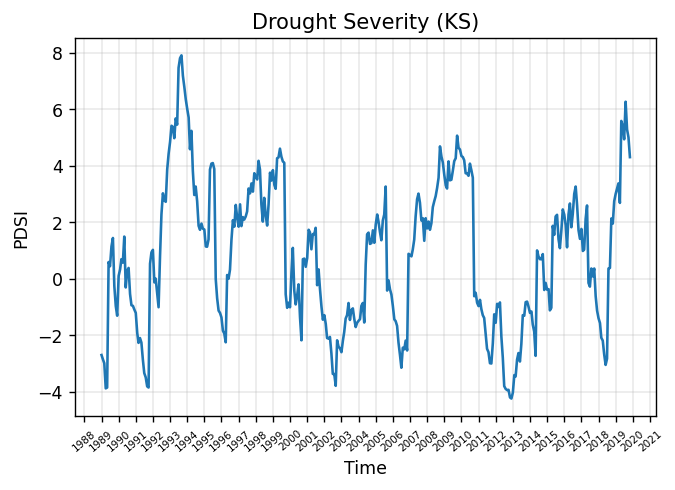

In [520]:
ax = plt.gca()
drought_plot = sns.lineplot(data=df_drought_KS, x='Date', y='PDSI', ci=None)
drought_plot.set(xlabel='Time', ylabel='PDSI')
drought_plot.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,2), interval=1))
plt.draw()
ax.set_xticklabels(item.get_text()[:4] for item in ax.get_xticklabels())
plt.xticks(fontsize=6, rotation=40)
plt.title('Drought Severity (KS)')
plt.grid(linestyle='-', linewidth=0.25)
plt.show()

In [521]:
train_KS, test_KS = train_test_split(df_drought_KS, test_size=0.2, shuffle=False)
print(train_KS.shape)
print(test_KS.shape)

(296, 6)
(75, 6)


#### Washington (WA) data

In [522]:
df_drought_WA['Month'] = df_drought_WA.Month.map('{:02}'.format)
df_drought_WA['Day'] = 1
df_drought_WA['Date'] = pd.to_datetime(df_drought_WA[['Year', 'Month', 'Day']])
df_drought_WA['month_year'] = pd.to_datetime(df_drought_WA['Date']).dt.to_period('M')

print(df_drought_WA.shape)
df_drought_WA.head()

(371, 6)


,PDSI,Year,Month,Day,Date,month_year
0,-1.65,1989,01,1,1989-01-01,1989-01
1,-2.06,1989,02,1,1989-02-01,1989-02
2,-1.17,1989,03,1,1989-03-01,1989-03
3,-1.19,1989,04,1,1989-04-01,1989-04
4,-0.77,1989,05,1,1989-05-01,1989-05


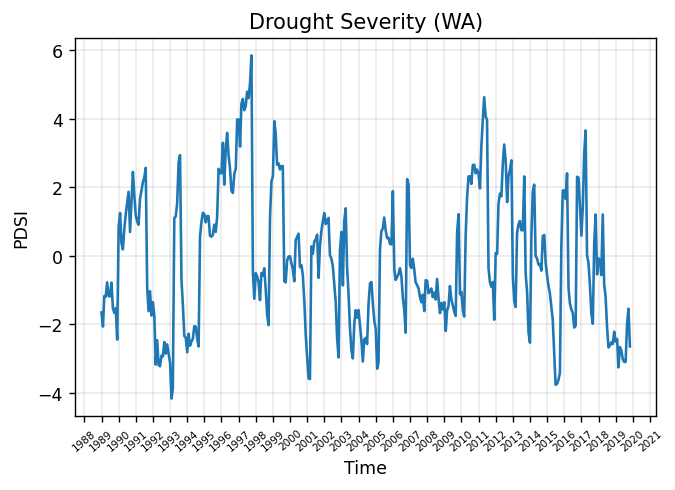

In [523]:
ax = plt.gca()
drought_plot = sns.lineplot(data=df_drought_WA, x='Date', y='PDSI', ci=None)
drought_plot.set(xlabel='Time', ylabel='PDSI')
drought_plot.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,2), interval=1))
plt.draw()
ax.set_xticklabels(item.get_text()[:4] for item in ax.get_xticklabels())
plt.xticks(fontsize=6, rotation=40)
plt.title('Drought Severity (WA)')
plt.grid(linestyle='-', linewidth=0.25)
plt.show()

### PDSI model

In [524]:
class HoltWinters:
    """Scikit-learn like interface for Holt-Winters method."""

    def __init__(self, season_len, alpha=0.5, beta=0.5, gamma=0.5):
        self.beta = beta
        self.alpha = alpha
        self.gamma = gamma
        self.season_len = season_len

    def fit(self, series):
        # note that unlike scikit-learn's fit method, it doesn't learn
        # the optimal model paramters, alpha, beta, gamma instead it takes
        # whatever the value the user specified the produces the predicted time
        # series, this of course can be changed.
        beta = self.beta
        alpha = self.alpha
        gamma = self.gamma
        season_len = self.season_len
        seasonals = self._initial_seasonal(series)

        # initial values
        predictions = []
        smooth = series[0]
        trend = self._initial_trend(series)
        predictions.append(smooth)

        for i in range(1, len(series)):
            value = series[i]
            previous_smooth = smooth
            seasonal = seasonals[i % season_len]
            smooth = alpha * (value - seasonal) + (1 - alpha) * (previous_smooth + trend)
            trend = beta * (smooth - previous_smooth) + (1 - beta) * trend
            seasonals[i % season_len] = gamma * (value - smooth) + (1 - gamma) * seasonal
            predictions.append(smooth + trend + seasonals[i % season_len])

        self.trend_ = trend
        self.smooth_ = smooth
        self.seasonals_ = seasonals
        self.predictions_ = predictions
        return self
    
    def _initial_trend(self, series):
        season_len = self.season_len
        total = 0.0
        for i in range(season_len):
            total += (series[i + season_len] - series[i]) / season_len

        trend = total / season_len
        return trend

    def _initial_seasonal(self, series):
        season_len = self.season_len
        n_seasons = len(series) // season_len

        season_averages = np.zeros(n_seasons)
        for j in range(n_seasons):
            start_index = season_len * j
            end_index = start_index + season_len
            season_average = np.sum(series[start_index:end_index]) / season_len
            season_averages[j] = season_average

        seasonals = np.zeros(season_len)
        seasons = np.arange(n_seasons)
        index = seasons * season_len
        for i in range(season_len):
            seasonal = np.sum(series[index + i] - season_averages) / n_seasons
            seasonals[i] = seasonal

        return seasonals

    def predict(self, n_preds=10):
        """
        Parameters
        ----------
        n_preds: int, default 10
            Predictions horizon. e.g. If the original input time series to the .fit
            method has a length of 50, then specifying n_preds = 10, will generate
            predictions for the next 10 steps. Resulting in a prediction length of 60.
        """
        predictions = self.predictions_
        original_series_len = len(predictions)
        for i in range(original_series_len, original_series_len + n_preds):
            m = i - original_series_len + 1
            prediction = self.smooth_ + m * self.trend_ + self.seasonals_[i % self.season_len]
            predictions.append(prediction)

        return predictions

In [525]:
def timeseries_cv_score(params, series, loss_function, season_len=1, n_splits=3):
    """
    Iterating over folds, train model on each fold's training set,
    forecast and calculate error on each fold's test set.
    """
    errors = []    
    alpha, beta, gamma = params
    time_series_split = TimeSeriesSplit(n_splits=n_splits) 

    for train, test in time_series_split.split(series):
        model = HoltWinters(season_len, alpha, beta, gamma)
        model.fit(series[train])

        # evaluate the prediction on the test set only
        predictions = model.predict(n_preds=len(test))
        test_predictions = predictions[-len(test):]
        test_actual = series[test]
        error = loss_function(test_actual, test_predictions)
        errors.append(error)

    return np.mean(errors)

#### Kansas (KS)

In [526]:
# provide initial values for model parameters' alpha, beta and gamma
# and leave out the last 20 points of our time series as test set
series = df_drought_KS['PDSI'] + 100 # temporary modification to ensure values are positive for error calculations
x = [0, 0, 0]
test_size = 1
data = series.values[:-test_size]
opt = minimize(timeseries_cv_score, x0=x, args=(data, mean_squared_log_error), 
               method='TNC', bounds=((0, 1), (0, 1), (0, 1)))
print('original parameters: {}'.format(str(x)))
print('best parameters: {}'.format(str(opt.x)))

original parameters: [0, 0, 0]
best parameters: [0.01132348 0.03504385 0.00691111]


In [527]:
# retrieve optimal values, train the finnal model with them
# and generating forecast for next 50 hours
season_len = 185
alpha_final, beta_final, gamma_final = opt.x
model = HoltWinters(season_len, alpha_final, beta_final, gamma_final)
model.fit(data)
predictions = model.predict(n_preds=1)

print('original series length: ', len(series))
print('prediction length: ', len(predictions))

original series length:  371
prediction length:  371


In [528]:
# evaluation metric
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [529]:
data = series.values
error = mean_absolute_percentage_error(data, predictions[:len(series)])
print('Mean Absolute Percentage Error: {0:.2f}%'.format(error))

Mean Absolute Percentage Error: 1.86%


In [530]:
# bringing values back to normal
predictions[:] = [number - 100 for number in predictions]
data[:] = [number - 100 for number in data]

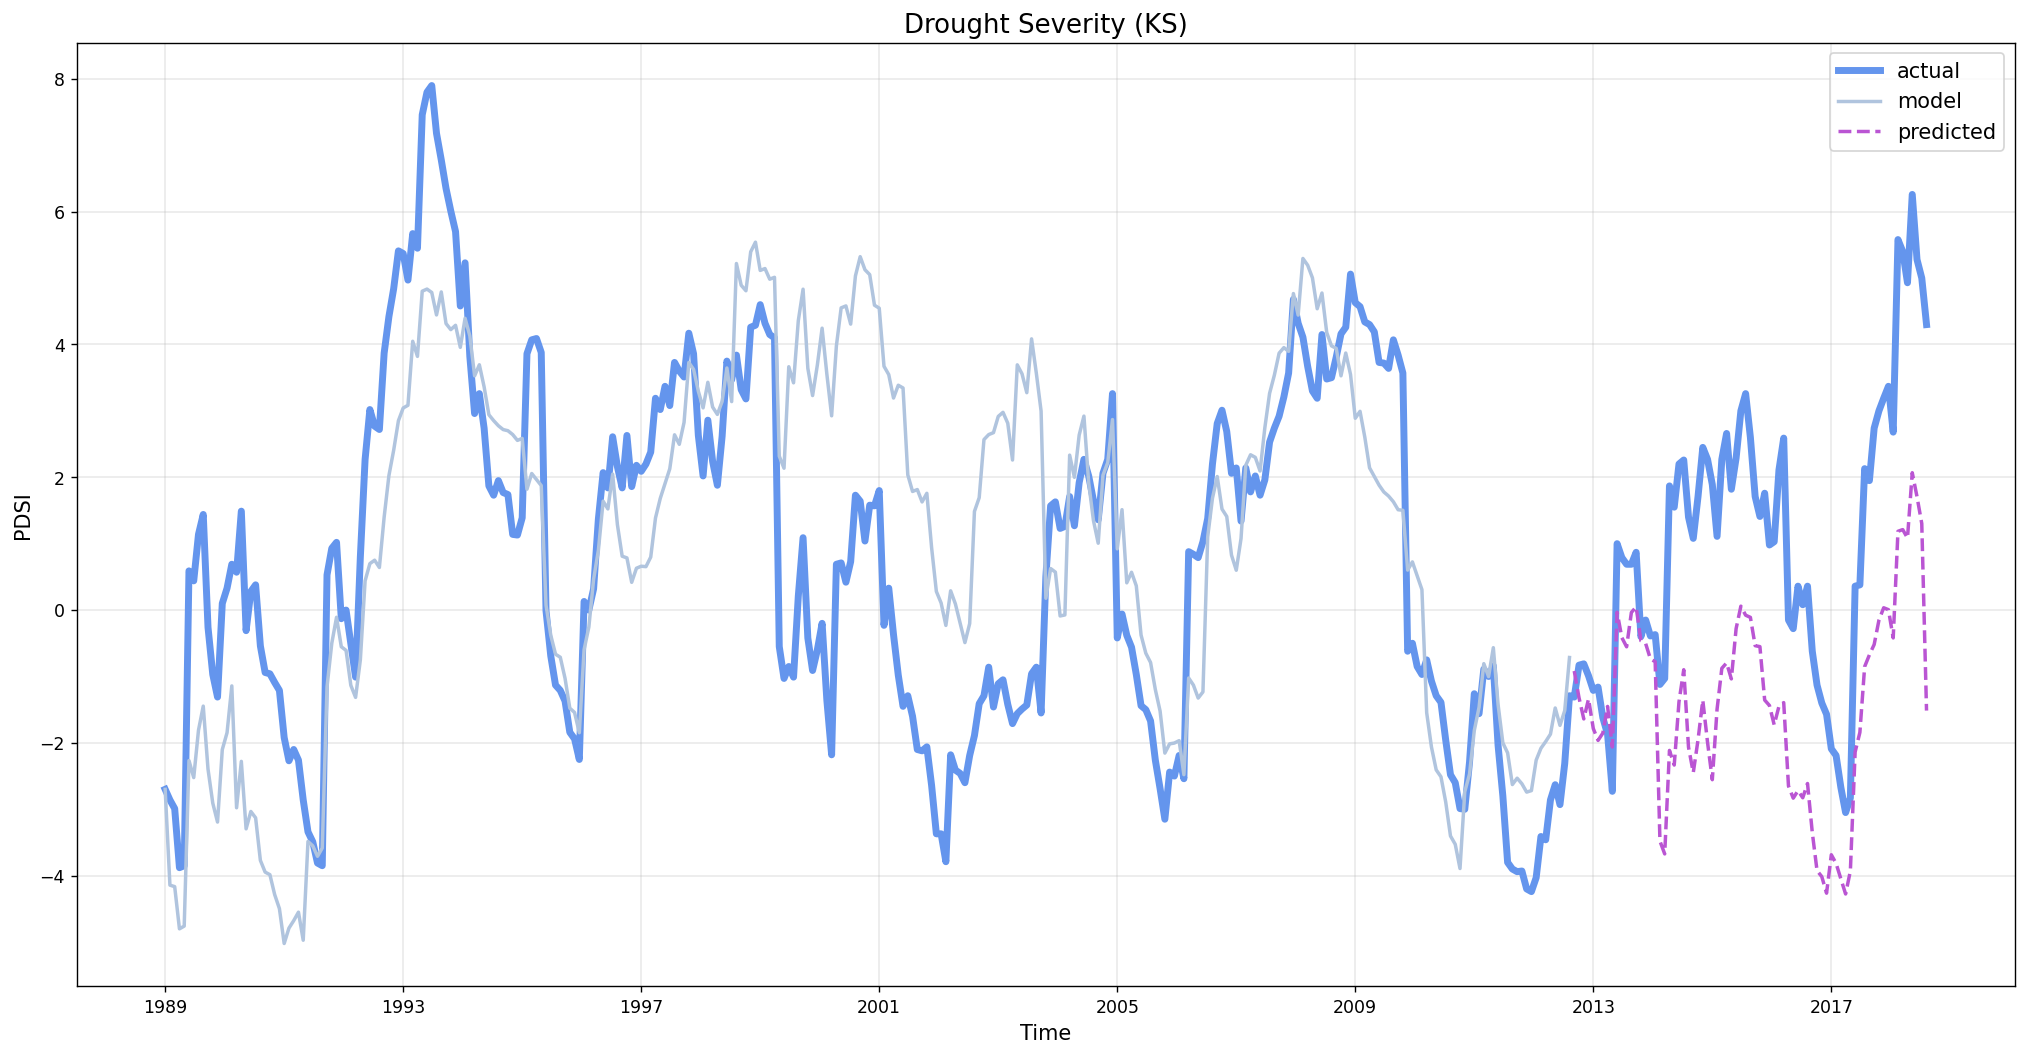

In [531]:
plt.figure(figsize=(20, 10))
plt.plot(data, label='actual', color='cornflowerblue', linewidth=4)
plt.plot(predictions[:296], label='model', color='lightsteelblue', linewidth=2)
plt.plot(range(371)[296:], predictions[296:], label='predicted', color='mediumorchid', linewidth=2, linestyle='--')
ax = plt.gca()
plt.draw()
#ax.set_xticklabels(str(df_drought_KS.at[i,'Date'])[:4] for i in [0,50,100,150,200,250,300,350]) 
ax.set_xticklabels(['', '1989', '1993', '1997', '2001', '2005', '2009', '2013', '2017'])
plt.title('Drought Severity (KS)', fontsize=15)
plt.axis('tight')
plt.xlabel('Time', fontsize=12)
plt.ylabel('PDSI', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(linestyle='-', linewidth=0.25)
plt.show()

#### Washington (WA)

In [532]:
series = df_drought_WA['PDSI'] + 200 # temporary modification to ensure values are positive for error calculations
x = [0, 0, 0]
test_size = 1
data = series.values[:-test_size]
opt = minimize(timeseries_cv_score, x0=x, args=(data, mean_squared_log_error), 
               method='TNC', bounds=((0, 1), (0, 1), (0, 1)))
print('original parameters: {}'.format(str(x)))
print('best parameters: {}'.format(str(opt.x)))

original parameters: [0, 0, 0]
best parameters: [0.02140171 0.03504359 0.00727386]


In [533]:
season_len = 185
alpha_final, beta_final, gamma_final = opt.x
model = HoltWinters(season_len, alpha_final, beta_final, gamma_final)
model.fit(data)
predictions = model.predict(n_preds=1)

print('original series length: ', len(series))
print('prediction length: ', len(predictions))

original series length:  371
prediction length:  371


In [534]:
data = series.values
error = mean_absolute_percentage_error(data, predictions[:len(series)])
print('Mean Absolute Percentage Error: {0:.2f}%'.format(error))

Mean Absolute Percentage Error: 0.48%


In [535]:
# bringing values back to normal
predictions[:] = [number - 200 for number in predictions]
data[:] = [number - 200 for number in data]

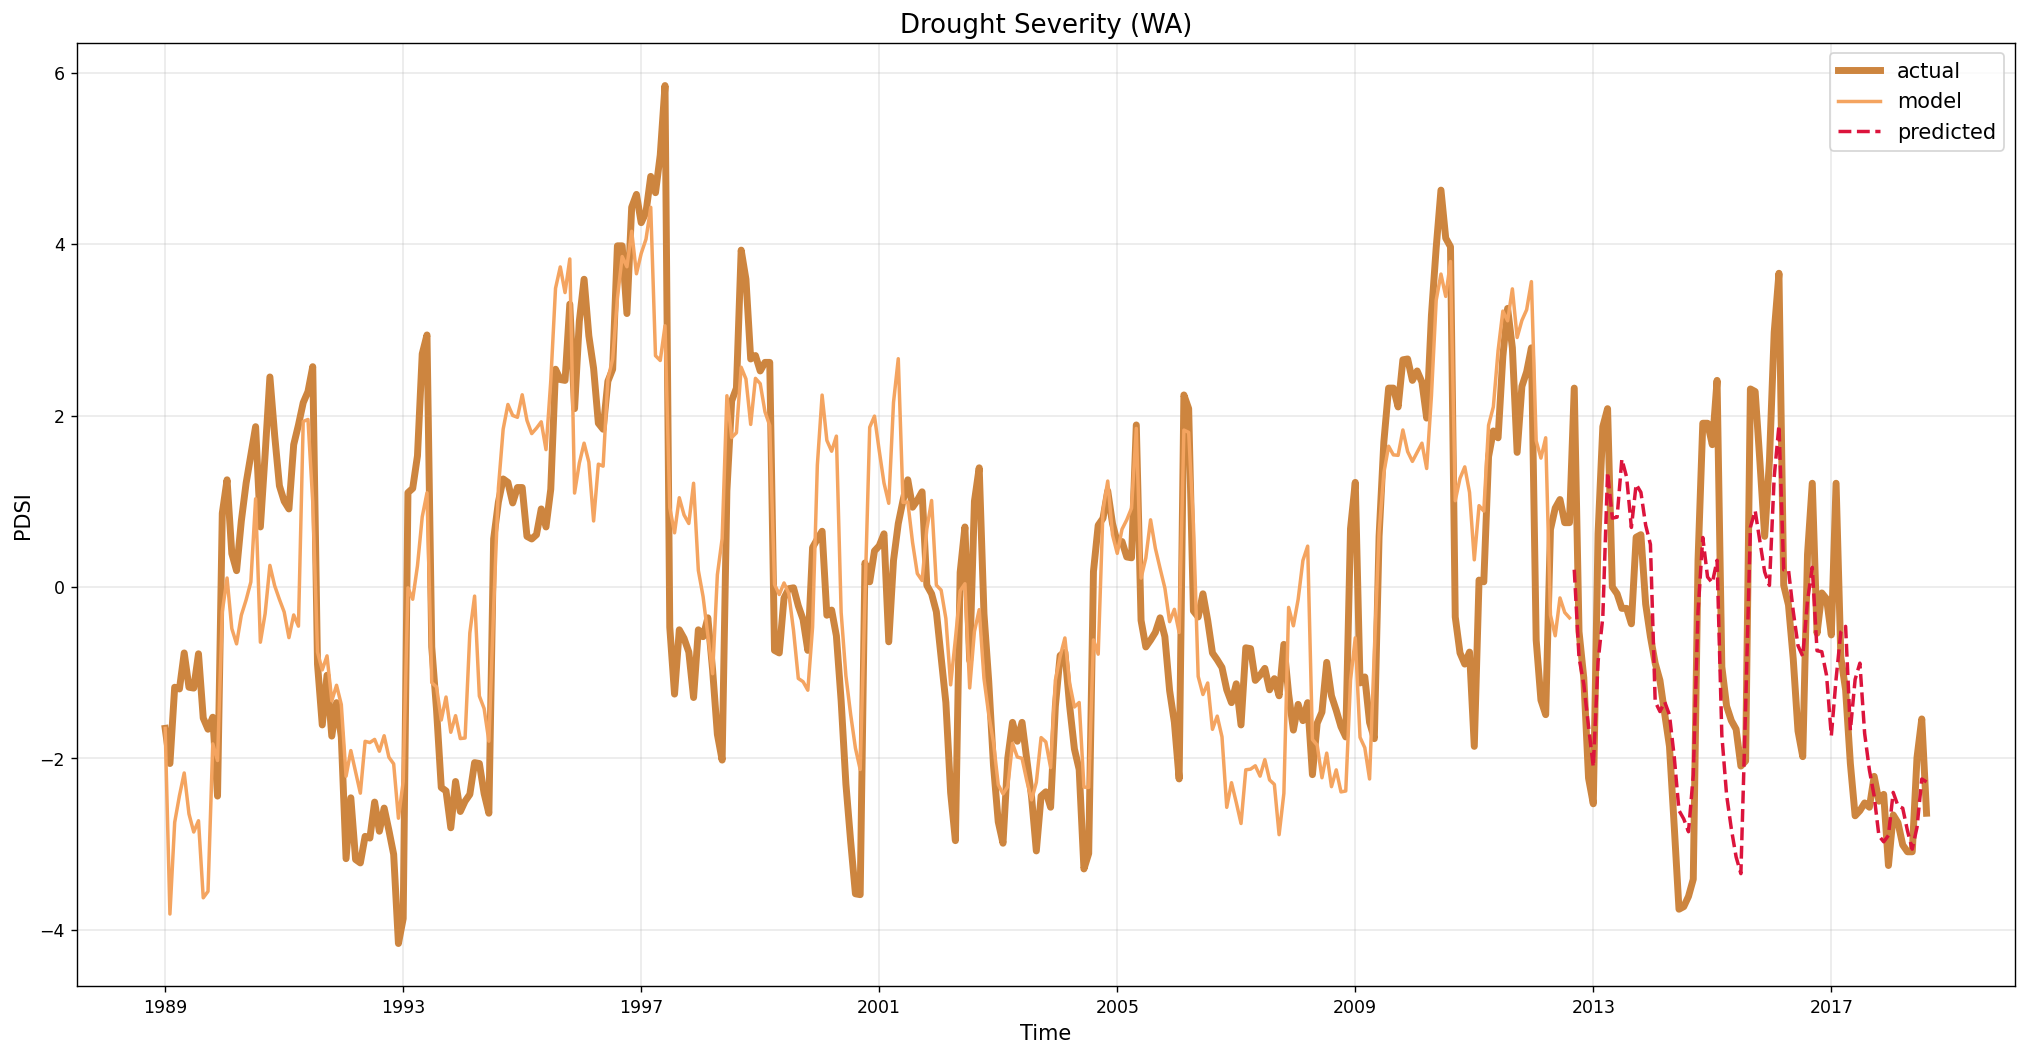

In [536]:
plt.figure(figsize=(20, 10))
plt.plot(data, label='actual', color='peru', linewidth=4)
plt.plot(predictions[:296], label='model', color='sandybrown', linewidth=2)
plt.plot(range(371)[296:], predictions[296:], label='predicted', color='crimson', linewidth=2, linestyle='--')
ax = plt.gca()
plt.draw()
ax.set_xticklabels(['', '1989', '1993', '1997', '2001', '2005', '2009', '2013', '2017'])
plt.title('Drought Severity (WA)', fontsize=15)
plt.axis('tight')
plt.xlabel('Time', fontsize=12)
plt.ylabel('PDSI', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(linestyle='-', linewidth=0.25)
plt.show()

### Loss ratio model
Climate factors with aggregations of historical causes of loss

In [537]:
def create_polynomial_regression_model(degree, X_train, X_test, Y_train, Y_test):
    "Creates a polynomial regression model for the given degree"
    poly_features = PolynomialFeatures(degree=degree)

    # transform the features to higher degree features.
    X_train_poly = poly_features.fit_transform(X_train)

    # fit the transformed features to Linear Regression
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, Y_train)

    # predicting on training data-set
    y_train_predicted = poly_model.predict(X_train_poly)

    # predicting on test data-set
    y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))

    # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_predicted))
    r2_train = r2_score(Y_train, y_train_predicted)

    # evaluating the model on test dataset
    rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predict))
    r2_test = r2_score(Y_test, y_test_predict)
    
    # Getting coefficients (polynomial regression)
    reg_label = "Inliers coef:%s - b:%0.2f" % \
                (np.array2string(poly_model.coef_, formatter={'float_kind': lambda fk: "%.3f" % fk}), poly_model.intercept_)
    print(reg_label)

    print("-------------------------------------------")
    print("Polynomial model performance for the training set")
    print("RMSE of training set is {}".format(rmse_train))
    print("R2 score of training set is {}".format(r2_train))

    print("-------------------------------------------")
    print("Polynomial model performance for the test set")
    print("RMSE of test set is {}".format(rmse_test))
    print("R2 score of test set is {}".format(r2_test))

#### Grant (KS)

In [538]:
X = df_Grant_model[['Avg_Temp', 'Precipitation', 'PDSI', 'temp', 'precip', 'other']]
Y = df_Grant_model['Loss Ratio']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [539]:
create_polynomial_regression_model(2, X_train, X_test, Y_train, Y_test)

Inliers coef:[-0.000 -4.851 9.101 8.996 13.311 8.675 -21.986 0.059 -0.198 -0.205 -2.148
 -1.590 -1.112 -0.304 -0.139 5.550 -3.144 6.695 0.095 2.023 1.882 5.091
 34.839 5.278 -26.807 -14.037 17.434 -12.613] - b:174.99
-------------------------------------------
Polynomial model performance for the training set
RMSE of training set is 0.036529272428870475
R2 score of training set is 0.9990375257665226
-------------------------------------------
Polynomial model performance for the test set
RMSE of test set is 3.2715568279977565
R2 score of test set is -5.427963571480237


#### Spokane (WA)

In [540]:
X = df_Spokane_model[['Avg_Temp', 'Precipitation', 'PDSI', 'temp', 'precip', 'other']]
Y = df_Spokane_model['Loss Ratio']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [541]:
create_polynomial_regression_model(2, X_train, X_test, Y_train, Y_test)

Inliers coef:[-0.000 -13.489 -246.634 53.948 -157.482 318.844 -161.362 0.091 6.483
 -1.555 2.533 -13.627 -2.395 7.199 4.896 -181.861 -98.687 33.913 1.316
 -3.789 49.557 8.180 72.156 -94.288 -135.350 314.909 98.223 -124.235] - b:645.41
-------------------------------------------
Polynomial model performance for the training set
RMSE of training set is 1.2512416414214417e-12
R2 score of training set is 1.0
-------------------------------------------
Polynomial model performance for the test set
RMSE of test set is 23.297185499599465
R2 score of test set is -4834.191650460891


#### Whitman (WA)

In [542]:
X = df_Whitman_model[['Avg_Temp', 'Precipitation', 'PDSI', 'temp', 'precip', 'other']]
Y = df_Whitman_model['Loss Ratio']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [543]:
create_polynomial_regression_model(2, X_train, X_test, Y_train, Y_test)

Inliers coef:[0.000 3.008 -37.389 -5.672 45.224 -32.179 -13.045 -0.039 0.293 0.149
 0.131 1.530 1.347 14.167 -0.642 -21.592 -10.251 -5.546 0.042 -2.903
 -1.539 -1.230 25.282 -32.302 52.245 40.016 -39.893 -25.397] - b:-83.58
-------------------------------------------
Polynomial model performance for the training set
RMSE of training set is 0.30280630411751236
R2 score of training set is 0.7820265009436946
-------------------------------------------
Polynomial model performance for the test set
RMSE of test set is 1.6984047064828225
R2 score of test set is -1.5121803411212085


### Loss ratio over time
Combining models obtaining temperature, precipitation, and PDSI from time with the one relating climate factors to loss ratio

#### Grant (KS)

In [892]:
series = df_Grant_model['Loss Ratio'] + 100 # temporary modification
x = [0, 0, 0]
test_size = 3
data = series.values[:-test_size]
opt = minimize(timeseries_cv_score, x0=x, args=(data, mean_squared_log_error), 
               method='TNC', bounds=((0, 1), (0, 1), (0, 1)))
print('original parameters: {}'.format(str(x)))
print('best parameters: {}'.format(str(opt.x)))

original parameters: [0, 0, 0]
best parameters: [0.20792468 0.4730206  0.29293999]


In [893]:
season_len = 14
alpha_final, beta_final, gamma_final = opt.x
model = HoltWinters(season_len, alpha_final, beta_final, gamma_final)
model.fit(data)
predictions = model.predict(n_preds=33)

print('original series length: ', len(series))
print('prediction length: ', len(predictions))

original series length:  31
prediction length:  61


In [894]:
data = series.values
error = mean_absolute_percentage_error(data, predictions[:len(series)])
print('Mean Absolute Percentage Error: {0:.2f}%'.format(error))

Mean Absolute Percentage Error: 0.58%


In [895]:
# bringing values back to normal
predictions[:] = [number - 100 for number in predictions]
data[:] = [number - 100 for number in data]

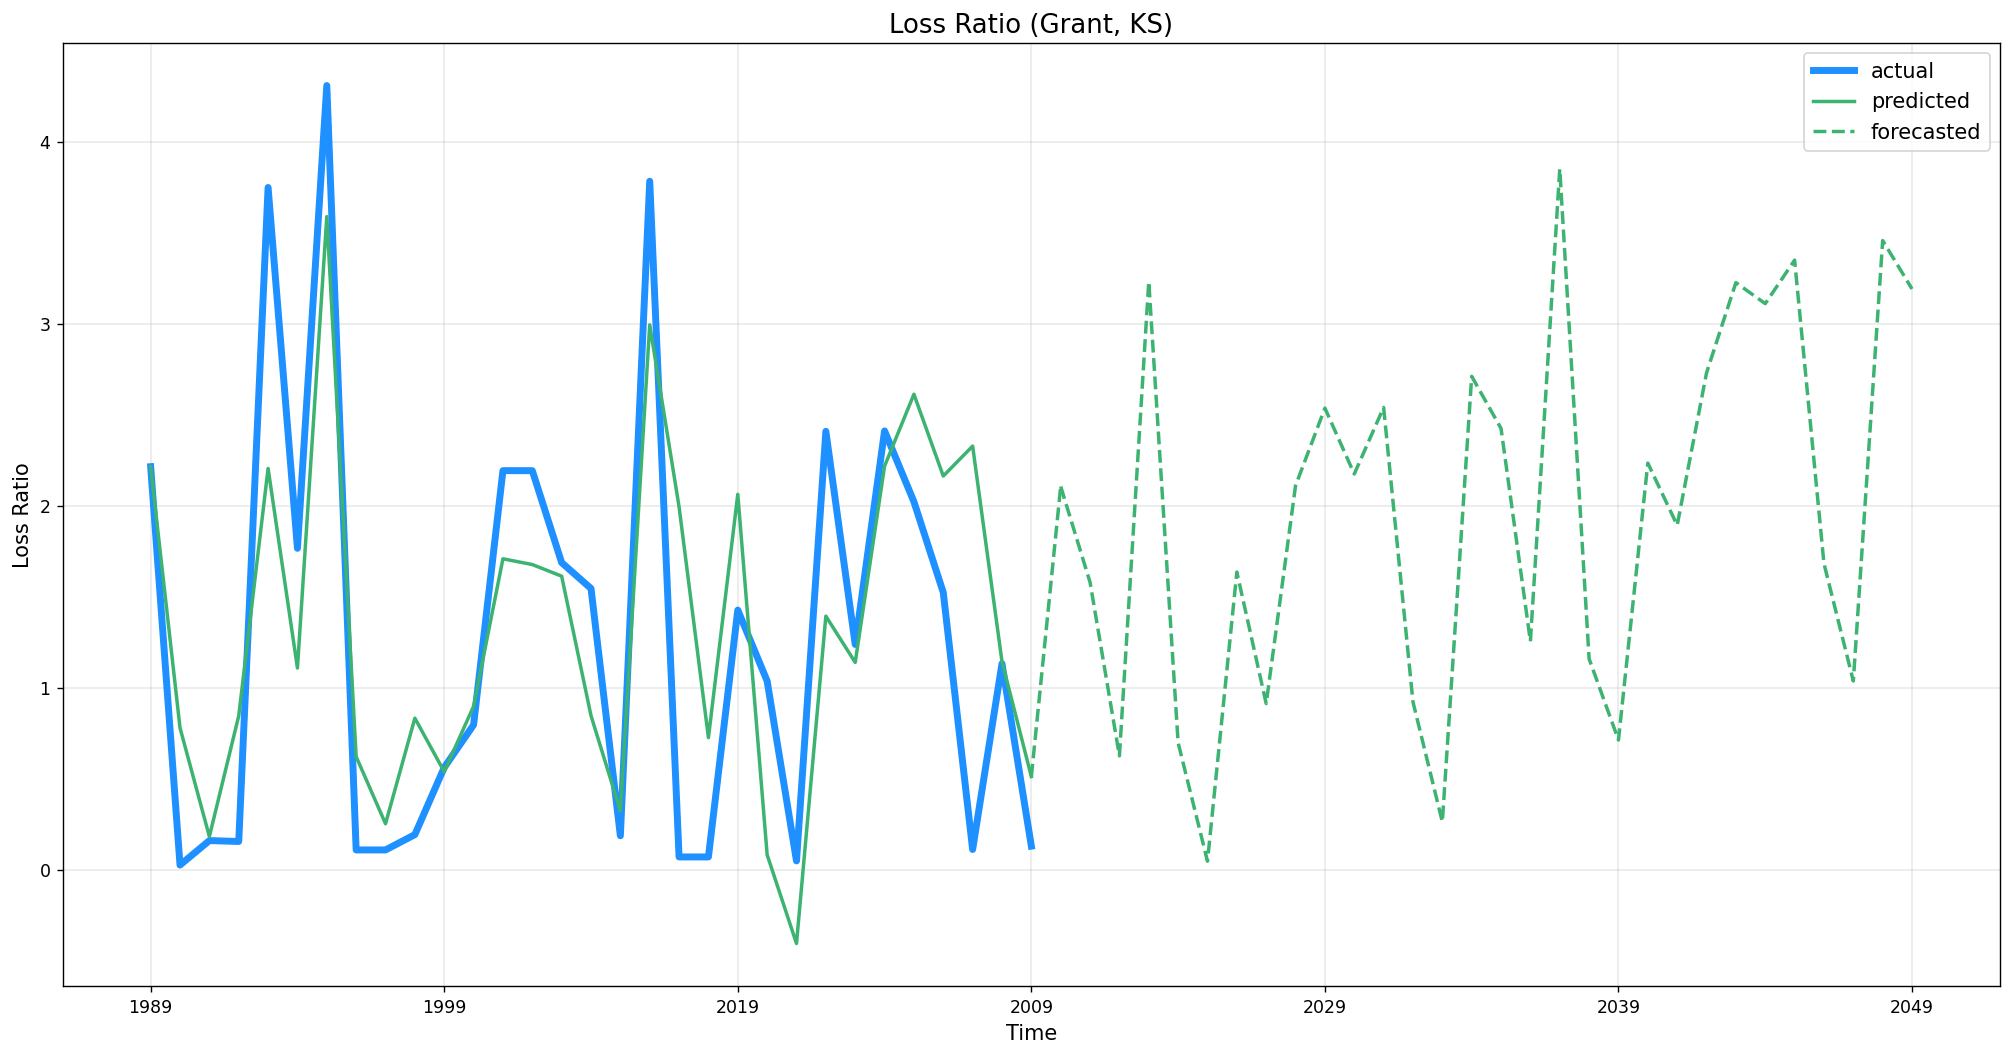

In [896]:
plt.figure(figsize=(20, 10))
plt.plot(data, label='actual', color='dodgerblue', linewidth=4)
plt.plot(predictions[:31], label='predicted', color='mediumseagreen', linewidth=2)
plt.plot(range(61)[31:], predictions[31:], label='forecasted', color='mediumseagreen', linewidth=2, linestyle='--')
plt.plot(range(61)[30:32], [predictions[30], predictions_adjusted[0]], color='mediumseagreen', linewidth=2, linestyle='--')
ax = plt.gca()
plt.draw()
ax.set_xticklabels(['', '1989', '1999', '2019', '2009', '2029', '2039', '2049'])
plt.title('Loss Ratio (Grant, KS)', fontsize=15)
plt.axis('tight')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Loss Ratio', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(linestyle='-', linewidth=0.25)
plt.show()

#### Spokane (WA)

In [966]:
series = df_Spokane_model['Loss Ratio'] + 100 # temporary modification
x = [0, 0, 0]
test_size = 3
data = series.values[:-test_size]
opt = minimize(timeseries_cv_score, x0=x, args=(data, mean_squared_log_error), 
               method='TNC', bounds=((0, 1), (0, 1), (0, 1)))
print('original parameters: {}'.format(str(x)))
print('best parameters: {}'.format(str(opt.x)))

original parameters: [0, 0, 0]
best parameters: [0.33306613 0.47857026 0.13867636]


In [967]:
season_len = 14
alpha_final, beta_final, gamma_final = opt.x
model = HoltWinters(season_len, alpha_final, beta_final, gamma_final)
model.fit(data)
predictions = model.predict(n_preds=33)

print('original series length: ', len(series))
print('prediction length: ', len(predictions))

original series length:  31
prediction length:  61


In [968]:
data = series.values
error = mean_absolute_percentage_error(data, predictions[:len(series)])
print('Mean Absolute Percentage Error: {0:.2f}%'.format(error))

Mean Absolute Percentage Error: 0.35%


In [969]:
# bringing values back to normal
predictions[:] = [number - 100 for number in predictions]
data[:] = [number - 100 for number in data]

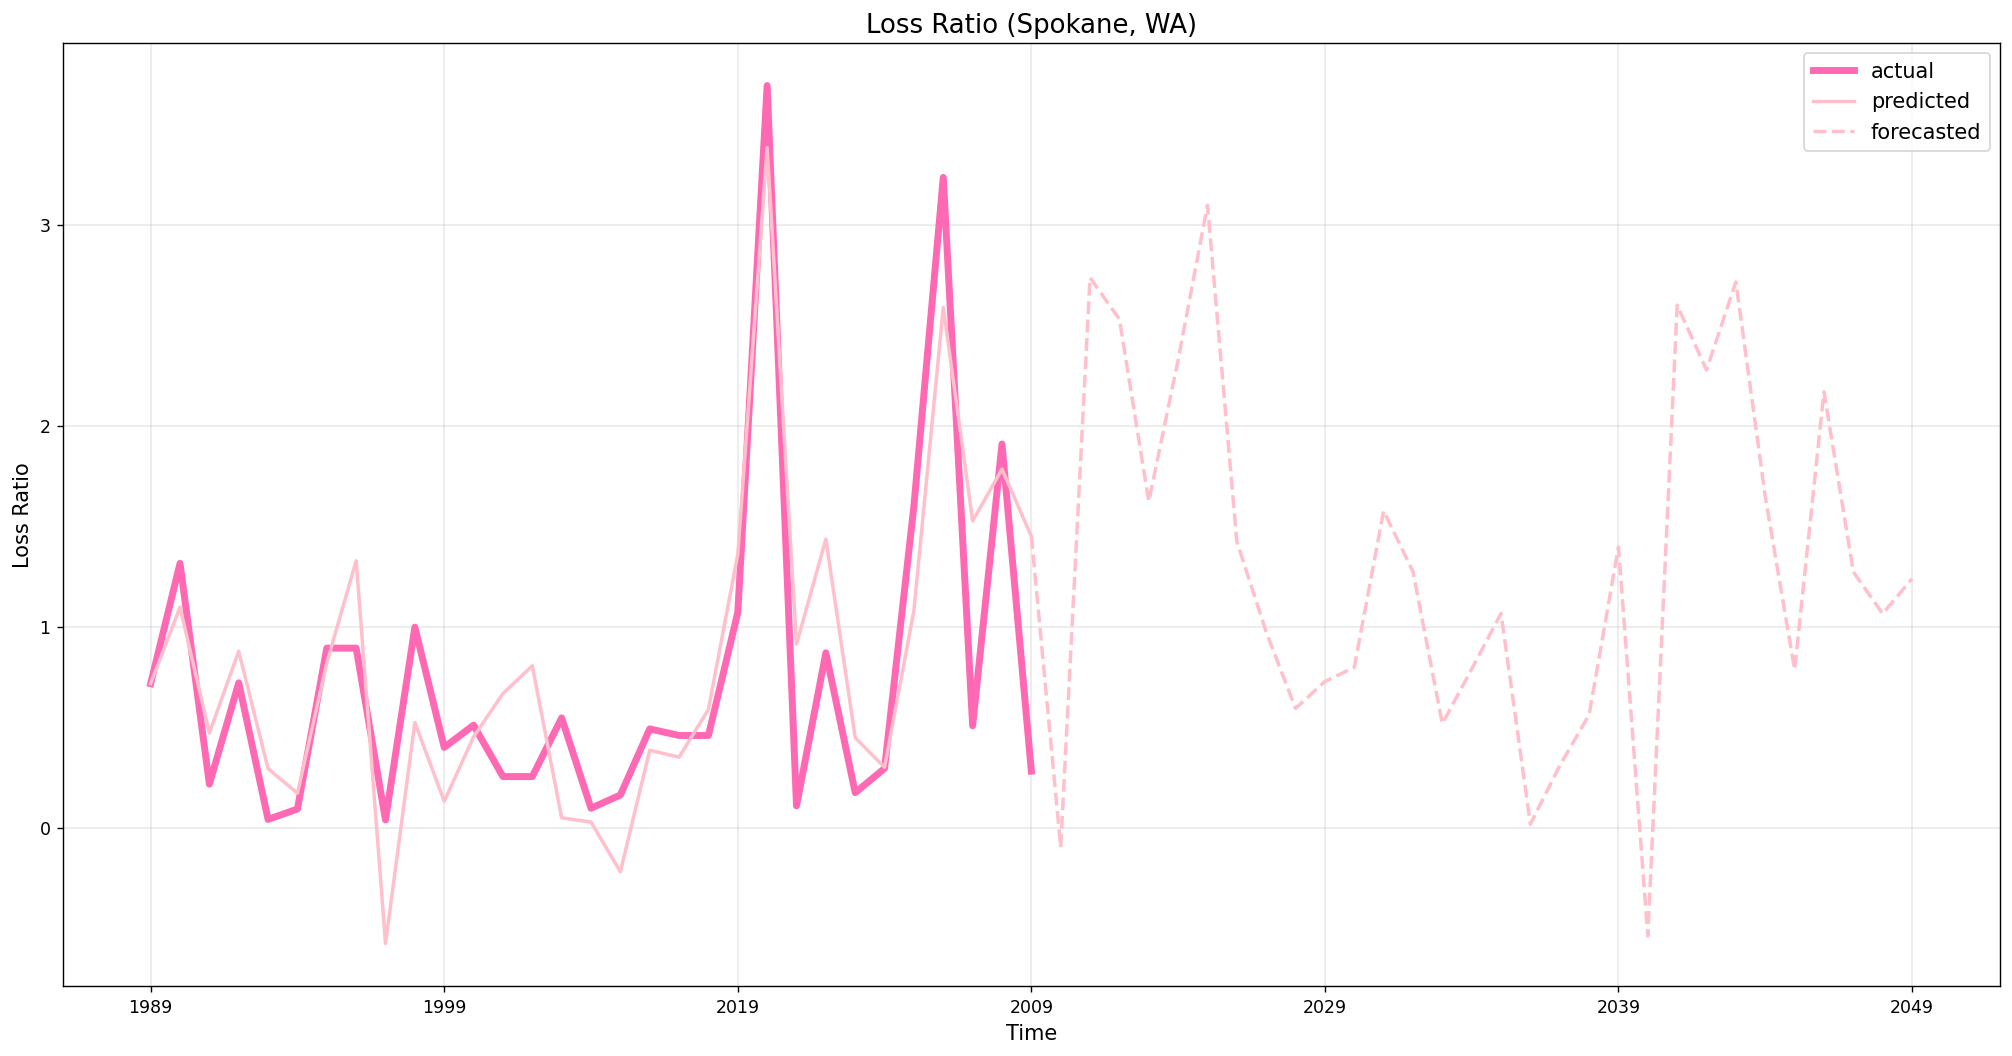

In [974]:
plt.figure(figsize=(20, 10))
plt.plot(data, label='actual', color='hotpink', linewidth=4)
plt.plot(predictions[:31], label='predicted', color='pink', linewidth=2)
plt.plot(range(61)[31:], predictions[31:], label='forecasted', color='pink', linewidth=2, linestyle='--')
plt.plot(range(61)[30:32], [predictions[30], predictions_adjusted[0]], color='pink', linewidth=2, linestyle='--')
ax = plt.gca()
plt.draw()
ax.set_xticklabels(['', '1989', '1999', '2019', '2009', '2029', '2039', '2049'])
plt.title('Loss Ratio (Spokane, WA)', fontsize=15)
plt.axis('tight')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Loss Ratio', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(linestyle='-', linewidth=0.25)
plt.show()

#### Whitman (WA)

In [1049]:
series = df_Whitman_model['Loss Ratio'] + 100 # temporary modification
x = [0, 0, 0]
test_size = 7
data = series.values[:-test_size]
opt = minimize(timeseries_cv_score, x0=x, args=(data, mean_squared_log_error), 
               method='TNC', bounds=((0, 1), (0, 1), (0, 1)))
print('original parameters: {}'.format(str(x)))
print('best parameters: {}'.format(str(opt.x)))

original parameters: [0, 0, 0]
best parameters: [0.35374826 0.45919399 0.09321572]


In [1050]:
season_len = 12
alpha_final, beta_final, gamma_final = opt.x
model = HoltWinters(season_len, alpha_final, beta_final, gamma_final)
model.fit(data)
predictions = model.predict(n_preds=35)

print('original series length: ', len(series))
print('prediction length: ', len(predictions))

original series length:  33
prediction length:  61


In [1051]:
data = series.values
error = mean_absolute_percentage_error(data, predictions[:len(series)])
print('Mean Absolute Percentage Error: {0:.2f}%'.format(error))

Mean Absolute Percentage Error: 0.36%


In [1052]:
# bringing values back to normal
predictions[:] = [number - 100 for number in predictions]
data[:] = [number - 100 for number in data]

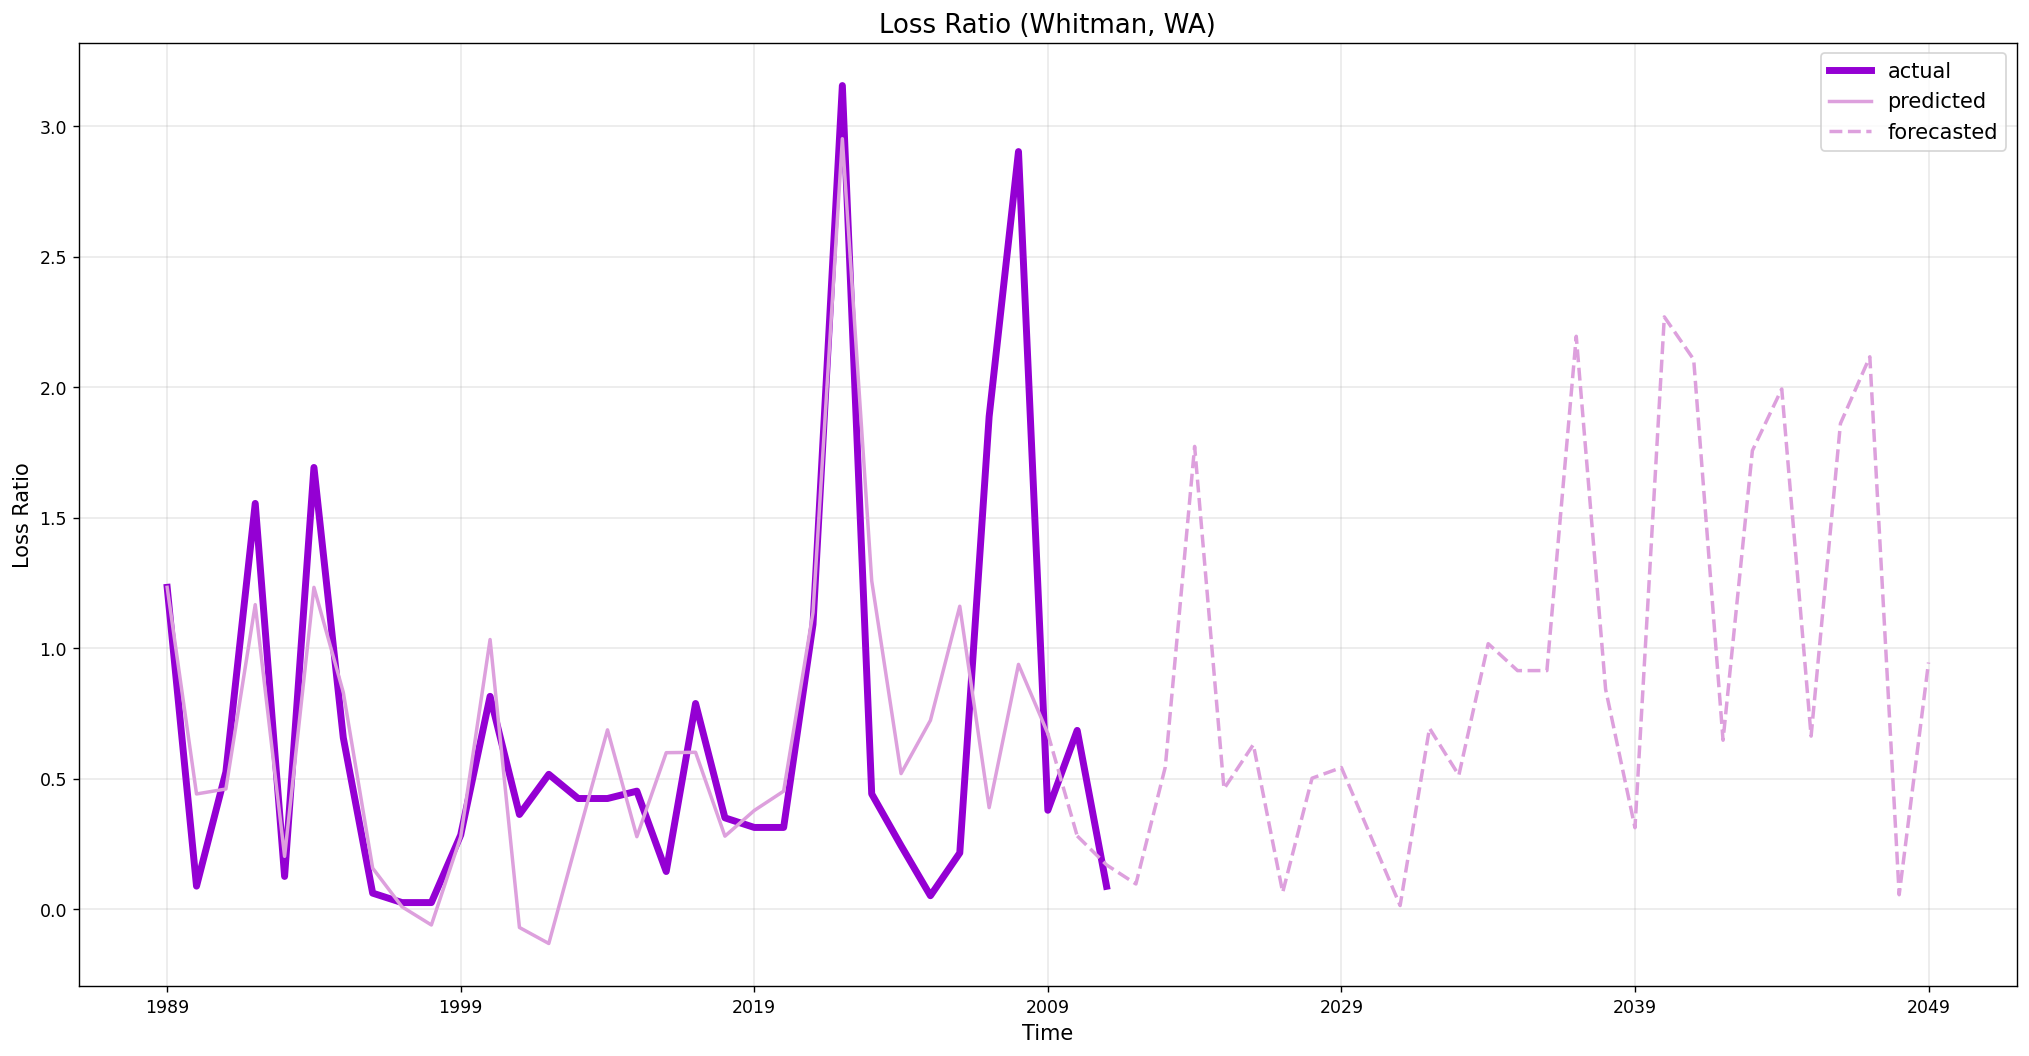

In [1066]:
plt.figure(figsize=(20, 10))
plt.plot(data, label='actual', color='darkviolet', linewidth=4)
plt.plot(predictions[:31], label='predicted', color='plum', linewidth=2)
plt.plot(range(61)[31:], predictions[31:], label='forecasted', color='plum', linewidth=2, linestyle='--')
plt.plot(range(61)[30:32], [predictions[30], predictions_adjusted[0]], color='plum', linewidth=2, linestyle='--')
ax = plt.gca()
plt.draw()
ax.set_xticklabels(['', '1989', '1999', '2019', '2009', '2029', '2039', '2049'])
plt.title('Loss Ratio (Whitman, WA)', fontsize=15)
plt.axis('tight')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Loss Ratio', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(linestyle='-', linewidth=0.25)
plt.show()

## 